In [15]:
import numpy as np

LINK_LENGTHS = [1, 1, 1]  
TARGET_POINT = np.array([1.5, 1.5, 0.5])
NUM_POSITIONS = 3  # Number of target positions
TARGET_POINTS = [
    np.array([1.5, 1.5, 0.5]),
    np.array([0.5, 1.8, 0.2]),
    np.array([1.8, 0.5, 0.7]),
]  # Three target points in the 3D plane
ANGLE_RANGE = (0, 2 * np.pi)
Z_RANGE = (0, LINK_LENGTHS[2])  # Range for the end effector's vertical position

NUM_GENERATIONS = 2000
MUTATION_RATE = 0.8
MUTATION_AMOUNT = 0.3
CROSSOVER_RATE = 0.9
BEST_SOLUTIONS = []
POPULATION_SIZE = 200

ADAPTIVE_INCREMENT = 0.5  # Increment for mutation rate when stuck
MIN_MUTATION_RATE = 0.1
MAX_MUTATION_RATE = 0.95
FITNESS_THRESHOLD = 0.0001  # Threshold for change in average fitness
ELITISM_COUNT = 10

# Initialization: Create a population of random angles for all positions
def initialize_population_multi_positions(pop_size, angle_range, num_positions):
    return np.random.uniform(
        angle_range[0], angle_range[1], (pop_size, num_positions, 2)
    )

def fitness_multi_positions(angles):
    """Evaluate the fitness of an individual for multiple positions."""
    total_distance = 0
    for i in range(NUM_POSITIONS):
        # Compute end effector position for each set of angles
        x = (
            LINK_LENGTHS[0] * np.cos(angles[i][0])
            + LINK_LENGTHS[1] * np.cos(angles[i][0] + angles[i][1])
        )
        y = (
            LINK_LENGTHS[0] * np.sin(angles[i][0])
            + LINK_LENGTHS[1] * np.sin(angles[i][0] + angles[i][1])
        )
        # For now, we'll assume that the z-coordinate change is linearly related to the angles.
        # This is a simplification and may need to be adjusted.
        z = angles[i][0] + angles[i][1]
        end_effector_position = np.array([x, y, z])

        # Calculate the distance to the target for each position
        distance = np.linalg.norm(end_effector_position - TARGET_POINTS[i])
        total_distance += distance

    # The fitness is the inverse of the total distance
    fitness = 1 / (1 + total_distance)  # Adding 1 to avoid division by zero
    return fitness

# Evaluate the entire population for multiple positions
def evaluate_population_multi_positions(population):
    return np.array([fitness_multi_positions(ind) for ind in population])

# Modifying the compute_positions function to compute 3D positions
def compute_positions(angles):
    """Compute the positions of the joints and end effector for given angles in 3D."""
    x1 = LINK_LENGTHS[0] * np.cos(angles[0])
    y1 = LINK_LENGTHS[0] * np.sin(angles[0])
    z1 = 0  # The Z-coordinate for the first joint remains 0

    x2 = x1 + LINK_LENGTHS[1] * np.cos(angles[0] + angles[1])
    y2 = y1 + LINK_LENGTHS[1] * np.sin(angles[0] + angles[1])
    z2 = angles[2]  # Using the third angle directly as the Z-coordinate of the end effector

    return [(0, 0, 0), (x1, y1, z1), (x2, y2, z2)]

# # Testing
# sample_angles = [np.pi / 4, np.pi / 6, 1]
# sample_target = TARGET_POINTS[0]
# compute_positions(sample_angles), fitness(sample_angles, sample_target)

def tournament_selection(population, fitness_values, tournament_size=2):
    """Select two parents based on their fitnesses using tournament selection."""
    def select_one():
        selected_competitors = np.random.choice(len(population), size=tournament_size, replace=False)
        competitor_fitnesses = np.array([fitness_values[i] for i in selected_competitors])
        winner_index = selected_competitors[np.argmax(competitor_fitnesses)]
        return population[winner_index]

    # Select two parents
    parent1 = select_one()
    parent2 = select_one()
    while np.array_equal(parent1, parent2):  # Ensure distinct parents
        parent2 = select_one()

    return np.array([parent1, parent2])

def roulette_wheel_selection(population, fitness_values):
    """Select two parents based on their fitnesses using Roulette Wheel selection."""
    normalized_fitness = fitness_values / np.sum(fitness_values)
    parents_indices = np.random.choice(len(population), size=2, p=normalized_fitness)
    return population[parents_indices]

def crossover(parents):
    """Crossover: One-point Crossover for three angles"""
    if np.random.random() < CROSSOVER_RATE:
        crossover_point = np.random.randint(1, 3)  # Crossover point can be between any of the three angles
        offspring1 = np.concatenate((parents[0, :crossover_point], parents[1, crossover_point:]))
        offspring2 = np.concatenate((parents[1, :crossover_point], parents[0, crossover_point:]))
    else:
        # If no crossover, return the parents as the offspring
        offspring1, offspring2 = parents[0], parents[1]

    return offspring1, offspring2

# Modifying the mutation function to handle three angles
def mutate(individual):
    """Mutation: add noise to increase diversity for 3 angles"""
    for i in range(len(individual)):
        if np.random.rand() < MUTATION_RATE:
            mutation_value = np.random.uniform(-MUTATION_AMOUNT, MUTATION_AMOUNT)
            individual[i] += mutation_value
            # Ensure the angles remain within the specified range
            if i < 2:
                individual[i] = np.clip(individual[i], ANGLE_RANGE[0], ANGLE_RANGE[1])
            else:
                individual[i] = np.clip(individual[i], Z_ANGLE_RANGE[0], Z_ANGLE_RANGE[1])
    return individual

# # Update the create new generation function for the new representation
# def create_new_generation_multi_positions(population, fitness_values):
#     new_population = []
#     for _ in range(POPULATION_SIZE // 2):
#         parents = tournament_selection(population, fitness_values)
#         offspring1, offspring2 = crossover(parents)
#         new_population.append(mutate(offspring1))
#         new_population.append(mutate(offspring2))
#     return np.array(new_population)

# # Main Genetic Algorithm Loop for multiple positions
# def run_genetic_algorithm_multi_positions():
#     population = initialize_population_multi_positions(
#         POPULATION_SIZE, ANGLE_RANGE, NUM_POSITIONS
#     )

#     for generation in range(NUM_GENERATIONS):
#         fitness_values = evaluate_population_multi_positions(population)

#         best_idx = np.argmax(fitness_values)
#         best_solution = population[best_idx]
#         BEST_SOLUTIONS.append((best_solution, fitness_values[best_idx]))

#         population = create_new_generation_multi_positions(population, fitness_values)

#     return max(BEST_SOLUTIONS, key=lambda x: x[1])

# # Let's test our updated genetic algorithm for multiple positions
# best_overall_solution_multi_positions = run_genetic_algorithm_multi_positions()
# best_overall_solution_multi_positions

def create_new_generation_with_adaptations(population, fitness_values, prev_avg_fitness):
    global MUTATION_RATE
    
    # Sort population based on fitness values
    sorted_indices = np.argsort(fitness_values)[::-1]
    new_population = []

    # Elitism: Directly pass the best individuals to the next generation
    for i in range(ELITISM_COUNT):
        new_population.append(population[sorted_indices[i]])

    # Fill the rest of the generation by crossover and mutation
    for _ in range((POPULATION_SIZE - ELITISM_COUNT) // 2):
        parents = tournament_selection(population, fitness_values)
        offspring1, offspring2 = crossover(parents)
        new_population.append(mutate(offspring1))
        new_population.append(mutate(offspring2))
    
    # Compute average fitness and adjust mutation rate
    avg_fitness = np.mean(fitness_values)
    if abs(avg_fitness - prev_avg_fitness) < FITNESS_THRESHOLD:
        MUTATION_RATE = min(MUTATION_RATE + ADAPTIVE_INCREMENT, MAX_MUTATION_RATE)
    else:
        MUTATION_RATE = max(MUTATION_RATE - ADAPTIVE_INCREMENT, MIN_MUTATION_RATE)

    return np.array(new_population), avg_fitness

# Main Genetic Algorithm Loop with adaptations
def run_genetic_algorithm_with_adaptations():
    population = initialize_population_multi_positions(
        POPULATION_SIZE, ANGLE_RANGE, NUM_POSITIONS
    )
    prev_avg_fitness = 0

    for generation in range(NUM_GENERATIONS):
        fitness_values = evaluate_population_multi_positions(population)

        best_idx = np.argmax(fitness_values)
        best_solution = population[best_idx]
        BEST_SOLUTIONS.append((best_solution, fitness_values[best_idx]))

        population, prev_avg_fitness = create_new_generation_with_adaptations(
            population, fitness_values, prev_avg_fitness
        )

    return max(BEST_SOLUTIONS, key=lambda x: x[1])

# Reinitialize the BEST_SOLUTIONS list
BEST_SOLUTIONS = []

# Rerun the genetic algorithm with the new strategies
best_solution_with_adaptations = run_genetic_algorithm_with_adaptations()
best_solution_with_adaptations



(array([[0.72694598, 0.        ],
        [0.95407411, 0.0857294 ],
        [0.        , 0.62087554]]),
 0.4116542484513194)

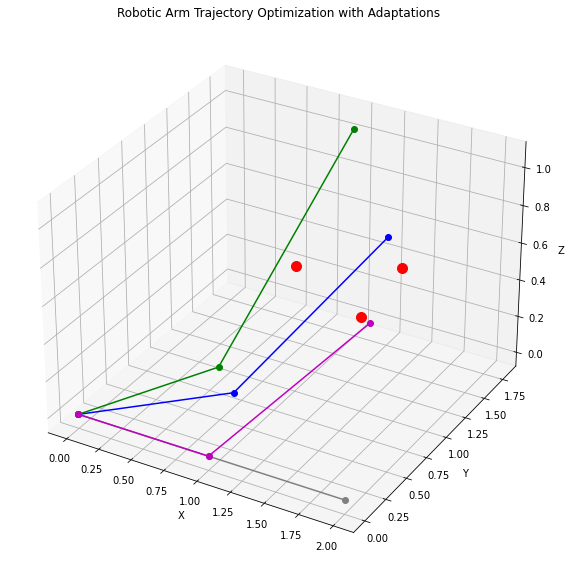

In [14]:
import matplotlib.pyplot as plt

def plot_robot_3d(positions, ax, color="b"):
    """Plot the robotic arm in 3D based on joint and end effector positions."""
    xs, ys, zs = zip(*positions)
    ax.plot(xs, ys, zs, "-o", color=color)

def compute_positions_3d(angles):
    """Compute the positions of the joints and end effector for given angles in 3D."""
    x1 = LINK_LENGTHS[0] * np.cos(angles[0])
    y1 = LINK_LENGTHS[0] * np.sin(angles[0])
    z1 = 0  # Assuming no vertical movement for the first link

    x2 = x1 + LINK_LENGTHS[1] * np.cos(angles[0] + angles[1])
    y2 = y1 + LINK_LENGTHS[1] * np.sin(angles[0] + angles[1])
    # For the z-coordinate, we assume it's linearly related to the angles.
    z2 = angles[0] + angles[1]

    return [(0, 0, 0), (x1, y1, z1), (x2, y2, z2)]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Robotic Arm Trajectory Optimization with Adaptations")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Plot the initial robotic arm position (assuming angles [0, 0])
initial_positions_3d = compute_positions_3d([0, 0])
plot_robot_3d(initial_positions_3d, ax, color="gray")

# Plot the target points
for target in TARGET_POINTS:
    ax.scatter(*target, color="r", s=100, label="Target Point")

# Plot the robotic arm in the best solution positions
colors = ["b", "g", "m"]
for i, angles in enumerate(best_solution_with_adaptations[0]):
    best_positions_3d = compute_positions_3d(angles)
    plot_robot_3d(best_positions_3d, ax, color=colors[i])

# Show the plot with interactions enabled
plt.show()



